In [2]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
!ls

data  data.zip	sample_data


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("data.zip", "r")
zip_ref.extractall()

In [0]:
import tensorflow as tf

#ignore warnings in the output
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12752960717191777142
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13881507640591648680
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14759763532237235740
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3455555263046955634
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



### Dataset

wget https://www.robots.ox.ac.uk/~vgg/data/text/mjsynth.tar.gz
 
tar -xvzf mjsynth.tar.gz

In [0]:
# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# total number of our output classes: len(char_list)
# char_list='০১২৩৪৫৬৭৮৯অআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণরযশহতথদধনলসপফবভমবড়ঢ়য়'
char_list = string.ascii_letters+string.digits
 
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [0]:
path = 'data'
 
 
# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 0
 
i =1 
flag = 0
 
for root, dirnames, filenames in os.walk(path):
 
    for f_name in fnmatch.filter(filenames, '*.jpg'):
        # read input image and convert into gray scale image
        img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)   
 
        # convert each image of shape (32, 128, 1)
        w, h = img.shape
        if h > 128 or w > 32:
            continue
        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))
 
        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
        
        # Normalize each image
        img = img/255.
        
        # get the text from the image
        txt = f_name.split('_')[1]
        
        # compute maximum length of the text
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
        # split the 150000 data into validation and training dataset as 10% and 90% respectively
        if i%10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 
        
        # break the loop if total data is 150000
        if i == 150000:
            flag = 1
            break
        i+=1
    if flag == 1:
        break

In [0]:
# pad each output label to maximum text length
 
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

### Network Archtecture

In [0]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [10]:
act_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 32, 256)        5900

### Loss Function

In [0]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [0]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [0]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [14]:
batch_size = 256
epochs = 500
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Train on 5203 samples, validate on 578 samples
Epoch 1/500
5203/5203 [==============================] - 35s 7ms/step - loss: 35.5026 - val_loss: 28.5718

Epoch 00001: val_loss improved from inf to 28.57184, saving model to best_model.hdf5
Epoch 2/500
5203/5203 [==============================] - 18s 4ms/step - loss: 28.2676 - val_loss: 28.1114

Epoch 00002: val_loss improved from 28.57184 to 28.11139, saving model to best_model.hdf5
Epoch 3/500
5203/5203 [==============================] - 18s 4ms/step - loss: 27.8610 - val_loss: 27.5848

Epoch 00003: val_loss improved from 28.11139 to 27.58480, saving model to best_model.hdf5
Epoch 4/500
5203/5203 [==============================] - 18s 4ms/step - loss: 27.5529 - val_loss: 27.7884

Epoch 00004: val_loss did not improve from 27.58480
Epoch 5/500
5203/5203 [==============================] - 18s 4ms/step - loss: 27.2496 - val_loss: 27.3001

Epoch 00005: val_loss improved from 27.58480 to 27.30014, saving model to best_model.hdf5
Epoch 6/500

### Test the Model

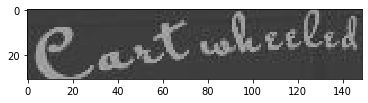

predicted text = Euiuhala



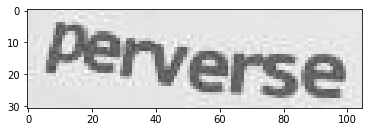

predicted text = perverse



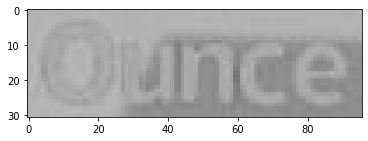

predicted text = Dnce



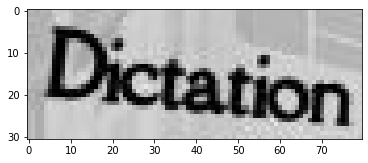

predicted text = Dictation



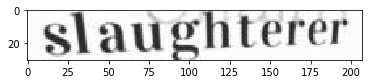

predicted text = slaughitery



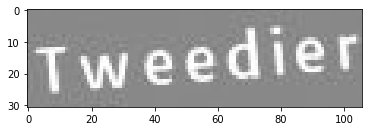

predicted text = Tweedierr



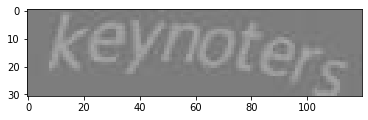

predicted text = keynoters



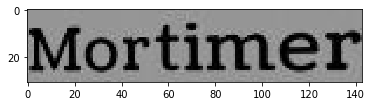

predicted text = Mortimer



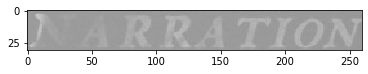

predicted text = IRATIO



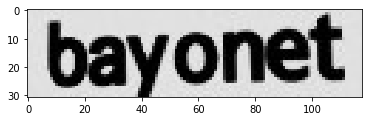

predicted text = bayonet



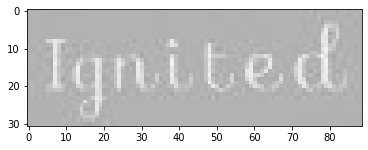

predicted text = Ignited



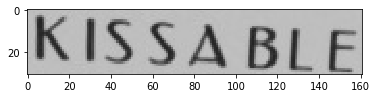

predicted text = NISSABLE



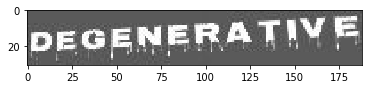

predicted text = SOSNERATNE



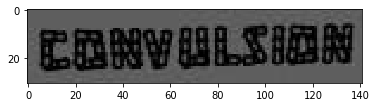

predicted text = Banansin



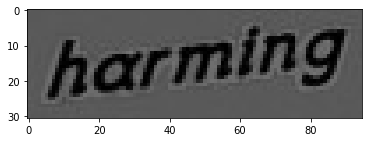

predicted text = harming



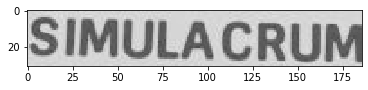

predicted text = SIMULACRUN



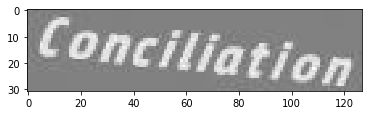

predicted text = Conciliation



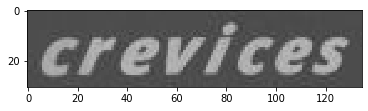

predicted text = arevices



In [85]:
import glob
import matplotlib.pyplot as plt
def get_image_resize(img):
    # for i in f_name:
    # img = cv2.imread(i,0)
    h,w= img.shape
    width = (128,32)
    img_resize = cv2.resize(img,(128,32))
    # print("resize image function",img.shape,img_resize.shape)
    return img_resize



def preprocess(img_):
    image_list=[]
    for f_name in img_:
        img = cv2.cvtColor(cv2.imread(f_name), cv2.COLOR_BGR2GRAY)   
        # convert each image of shape (32, 128, 1)
        w, h = img.shape
        if h > 128 or w > 32:
            img = get_image_resize(img)
            w, h = img.shape
        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))

        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)

        img = np.expand_dims(img , axis = 2)
        img = img/255.
        image_list.append(img)
    return image_list

img = glob.glob("data/test/*")
img_list = preprocess(img)
# print(img_list)
valid_img = np.array(img_list)
# print(img)
# load the saved best model weights
act_model.load_weights('best_model.hdf5')
 
# predict outputs on validation images
# print(valid_img[0].shape)
prediction = act_model.predict(valid_img)

out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],greedy=False)[0][0])
# print(out) 
# see the results
i = 0
for x,img_name in zip(out,img):
    # print(x)
    img = cv2.imread(img_name)
    plt.imshow(img)
    plt.show()
    # print("original_text =  ", img_name.split("/")[-1])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1